# LRS tutorial 2

Baselining, noise estimation, calibration, and detector vs data structure

## 2x2 Run1 Reflow v11

Bookkeeping:
- https://wiki.dunescience.org/wiki/MiniRun_6
- https://wiki.dunescience.org/wiki/2x2_Campaign_Overview#2x2_reflows

In [ ]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib import colors, ticker
import itertools

!pip install ./h5flow
from h5flow.data import dereference
from proto_nd_flow.util.lut import LUT

Processing ./h5flow
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31716 sha256=d72afa0290d245e5ee836ea49e5ccfeacd70a924d59796f333c6d3af4317d3e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-jqaq_oda/wheels/f1/5d/58/77983378fc64f41b62b695d5a44d952fa4c38d69af5c3ba1f2
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [ ]:
# load csv generated in lrs_sanity_check from yaml file proto_nd_flow
channel_status = pd.read_csv('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_status/channel_status.csv', header=None).to_numpy()
print('Channel Status Shape:', np.shape(channel_status))

# load calibration csv as df
path = '/global/homes/j/jvmead/dune/lrs_sanity_check/calibration/data_calib.csv'
calib = pd.read_csv(path, header=None).to_numpy()
print(calib.shape)


fname = '/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july10_2024/nominal_hv/packet-0050018-2024_07_10_12_56_35_CDT.FLOW.hdf5'
f = h5py.File(fname)

Channel Status Shape: (8, 64)
(8, 64)


In [ ]:
max_events = 100
events = np.linspace(0,max_events,max_events+1,dtype=int)

light_wvfms = f['light/wvfm/data/']['samples'][events]/4.0
print(light_wvfms.shape)

sipm_hits = f['light/sipm_hits/data']
print(sipm_hits.dtype.names)
print(sipm_hits.shape)

(101, 8, 64, 1000)
('id', 'adc', 'chan', 'pos', 'sample_idx', 'ns', 'busy_ns', 'samples', 'sum', 'max', 'sum_spline', 'max_spline', 'ns_spline', 'rising_spline', 'rising_err_spline', 'fwhm_spline')
(112327,)


In [ ]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/wvfm_noise_filter.py#L97-L123
def min_range_baseline(array, segment_size=25, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

baselines, rms = min_range_baseline(light_wvfms)
print(baselines.shape)
print(rms.shape)

(101, 8, 64)
(101, 8, 64)


Let's have a quick sanity check to see if the baseline and the noise looks stable over the file

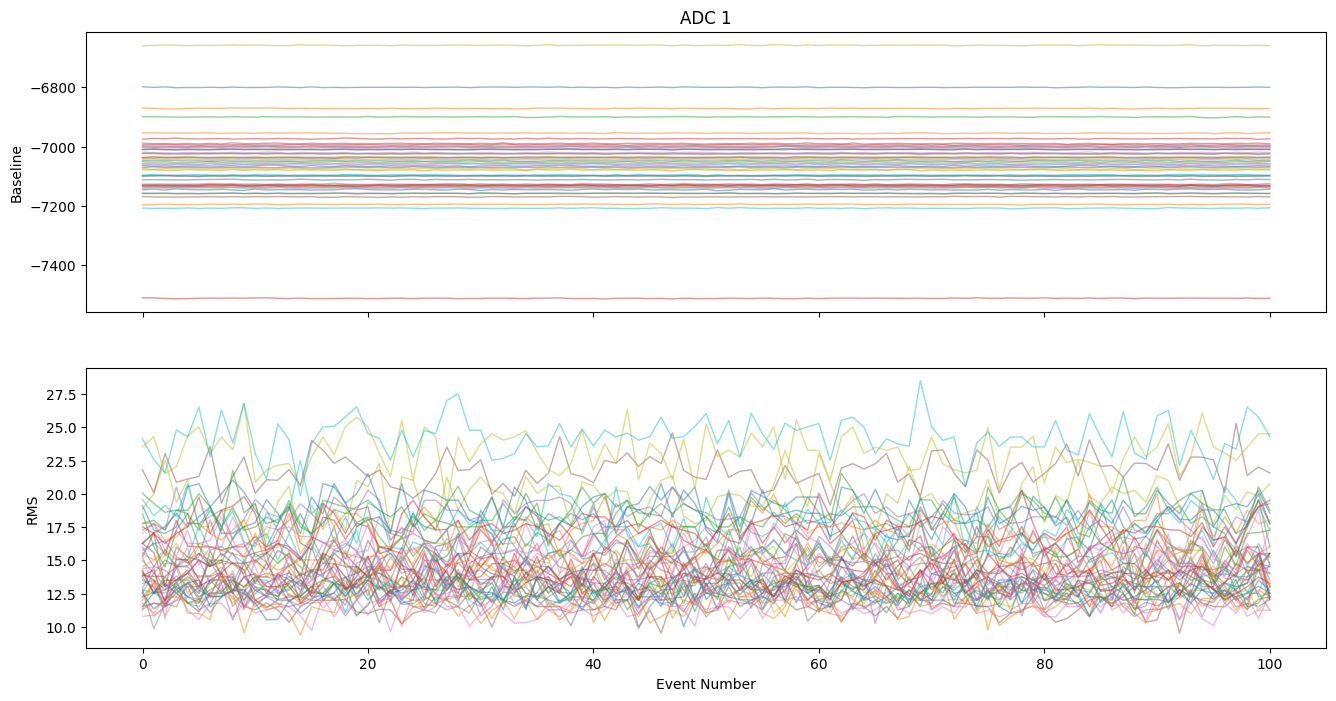

In [ ]:
def plot_adc_baseline_rms_over_events(adc, baselines, rms, channel_status=None, exclude_bad=True, exclude_inactive=True):
  """
  Plot baseline and RMS for all channels of a given ADC as a function of event number.
  Bad channels are shown with dashed lines or excluded if exclude_bad=True.

  Parameters:
    adc (int): ADC index (0-7)
    baselines (np.ndarray): shape (events, 8, 64)
    rms (np.ndarray): shape (events, 8, 64)
    channel_status (np.ndarray or None): shape (8, 64), 0=good, >0=bad
    exclude_bad (bool): If True, exclude bad channels; else, show with dashed lines
  """
  n_events = baselines.shape[0]
  fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
  ch_range = range(64)
  for ch in ch_range:
    is_bad = channel_status is not None and channel_status[adc, ch] > 0
    is_inactive = channel_status is not None and channel_status[adc, ch] == -1
    if exclude_inactive and is_inactive:
      continue
    if exclude_bad and is_bad:
      continue
    style = '--' if is_bad else '-'
    # if this channel has any event with baseline/RMS outside 5*stddev from  median, make alpha=1.0 and line thicker
    median_bline = np.median(baselines[:, adc, ch])
    stddev_bline = np.std(baselines[:, adc, ch])
    median_rms = np.median(rms[:, adc, ch])
    stddev_rms = np.std(rms[:, adc, ch])
    if np.any((baselines[:, adc, ch] > median_bline + 5*stddev_bline)
              | (baselines[:, adc, ch] < median_bline - 5*stddev_bline)
              | np.any(rms[:, adc, ch] > median_rms + 5*stddev_rms)
              | (stddev_bline > 150) | (stddev_rms > 150)
    ):
      alpha = 1.0
      linewidth = 2.0
      label = f'Ch {ch}' if not is_bad else None
    else:
      alpha = 0.5
      linewidth = 1.0
      label = None
    axs[0].plot(range(n_events), baselines[:, adc, ch], linewidth=linewidth, alpha=alpha, label=label)
    axs[1].plot(range(n_events), rms[:, adc, ch], linewidth=linewidth, alpha=alpha, label=label)
  axs[0].set_ylabel('Baseline')
  axs[1].set_ylabel('RMS')
  axs[1].set_xlabel('Event Number')
  axs[0].set_title(f'ADC {adc}')
  # Place legend to the right of the plot
  handles, labels = axs[0].get_legend_handles_labels()
  if handles:
    axs[0].legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, fontsize='small', title='Channels')
  plt.show()


plot_adc_baseline_rms_over_events(1, baselines, rms)

Now let's look at some waveforms! We will subtract the baseline and calibrate!

In [ ]:
light_wvfms_baselined = light_wvfms - baselines[:, :, :, np.newaxis]
print(light_wvfms_baselined.shape)
cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
rms_calib = rms * calib[np.newaxis, :, :]

(101, 8, 64, 1000)


In [ ]:
def plot_waveforms(light_wvfms, event_id, exclude_mod0=False, adc_list=None, channel_list=None, overlay=False):
    for evt in event_id:
        samples = light_wvfms[evt]  # shape: (8, 64, 1000)
        if adc_list is None:
            adc_list = range(2, 8) if exclude_mod0 else range(8)
        for adc in adc_list:
            if channel_list is None:
                channel_range = range(samples.shape[1])
            else:
                channel_range = channel_list
            if overlay:
                plt.figure(figsize=(10, 3))
                for chan in channel_range:
                    plt.plot(samples[adc, chan, :], label=f'chan {chan}')
                plt.xlabel('Sample index')
                plt.ylabel('PE/sample')
                plt.xlim(0, samples.shape[2]-1)
                plt.title(f'adc: {adc}, overlay channels')
                plt.legend(fontsize='small', bbox_to_anchor=(1.01, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
            else:
                for chan in channel_range:
                    plt.figure(figsize=(10, 3))
                    plt.plot(samples[adc, chan, :])
                    plt.xlabel('Sample index')
                    plt.ylabel('PE/sample')
                    plt.xlim(0, samples.shape[2]-1)
                    plt.title(f'adc: {adc}, chan: {chan}')
                    plt.show()

Here we are plotting 6 adjacent channels, all on the same LCM-group

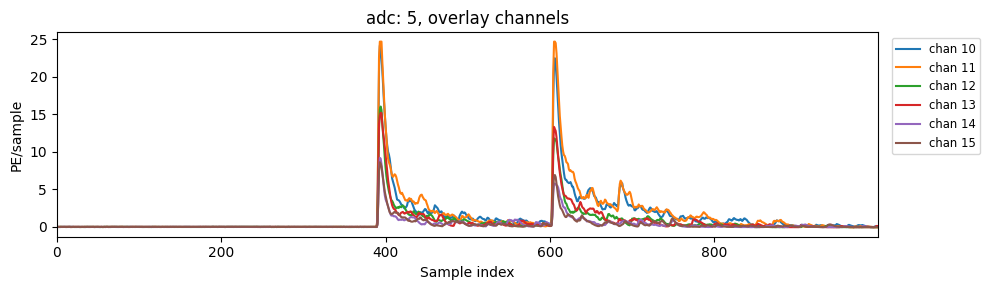

In [ ]:
evt = [85]
adc = [5]
chans = [10, 11, 12, 13, 14, 15]

plot_waveforms(cwvfms, event_id=evt, adc_list=adc, channel_list=chans, overlay=True)

Here are some 2x2 specific logical operations which are (mostly) applicable when navigating the TPC/EPCB/Trap/Channel levels so you don't have to dig around with geom files right off the bat:

In [ ]:
# a function to get the 6 channels on the same EPCB
def get_epcb_channels(channel):
    if channel < 0 or channel > 63:
        return []  # invalid
    epcb = channel // 6
    return [(epcb * 6 + i) for i in range(6)]

epcb_chans = get_epcb_channels(45)
print(f'Channels on the same EPCB as channel 45: {epcb_chans}')

# a function which takes the ADC and channel and gives a TPC number
def adc_channel_to_tpc(adc, channel):

    # use channels to determine if channel is in odd or even TPC
    if channel < 0 or channel > 63:
        return -1  # invalid
    if adc < 0 or adc > 7:
        return -1  # invalid
    tpc = adc + (channel // 32)
    tpc -= 1 if (adc % 2) else 0
    return tpc

tpc = adc_channel_to_tpc(3, 45)
print(f'The TPC number for ADC 3 and Channel 45 is: {tpc}')

# a function which takes a TPC number and gives a list of (adc, channel) tuples
def tpc_to_adc_channel(tpc):
    if tpc < 0 or tpc > 7:
        return []  # invalid
    channel_start = (tpc % 2) * 32
    channel_list = range(channel_start, channel_start + 32)
    channel_list = [ch for ch in channel_list if channel_status[tpc, ch] >= 0]

    adc_list = [tpc]
    if tpc % 2 == 0:
        adc_list.append(tpc + 1)
    else:
        adc_list.append(tpc - 1)

    adc_channel_list = [(adc, ch) for adc in adc_list for ch in channel_list]
    return adc_channel_list

adc_channel_list = tpc_to_adc_channel(tpc)
# Print ADC and Channel pairs in TPC {tpc} in rows of 6
print(f'ADC and Channel pairs in TPC {tpc}:')
for i in range(0, len(adc_channel_list), 6):
  print(adc_channel_list[i:i+6])

Channels on the same EPCB as channel 45: [42, 43, 44, 45, 46, 47]
The TPC number for ADC 3 and Channel 45 is: 3
ADC and Channel pairs in TPC 3:
[(3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41)]
[(3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47)]
[(3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57)]
[(3, 58), (3, 59), (3, 60), (3, 61), (3, 62), (3, 63)]
[(2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41)]
[(2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47)]
[(2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57)]
[(2, 58), (2, 59), (2, 60), (2, 61), (2, 62), (2, 63)]


We can plot the waveforms for each channel in an EPCB, and arrange subplots to represent the spatial arrangement within a TPC

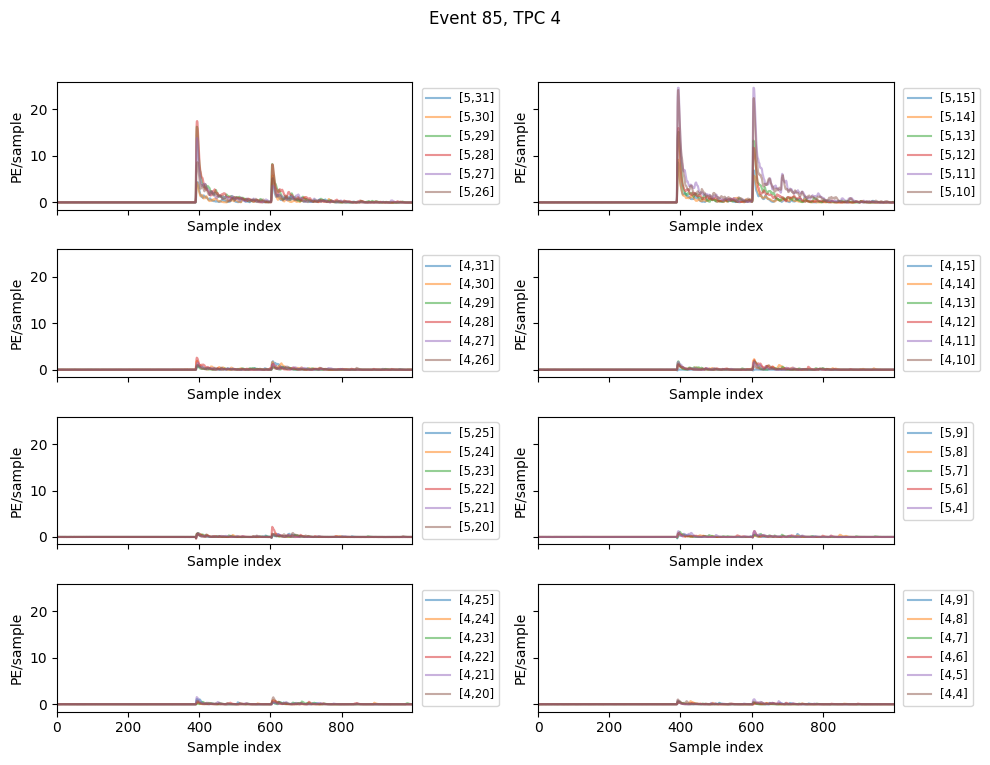

In [ ]:
def plot_tpc_waveforms(light_wvfms, event_id, tpc_number, channel_status=None):
  samples = light_wvfms[event_id]  # shape: (8, 64, 1000)
  if tpc_number < 0 or tpc_number > 8:
    print("Invalid TPC number. Must be 0-8.")
    return

  # Determine ADCs and channels for the TPC
  adc_channel_list = tpc_to_adc_channel(tpc_number)
  if not adc_channel_list:
    print(f"No valid ADC and channel pairs found for TPC {tpc_number}.")
    return
  # get unique adcs and channels in reverse order
  adc_list = sorted(set(adc for adc, ch in adc_channel_list), reverse=True)
  channel_list = sorted(set(ch for adc, ch in adc_channel_list), reverse=True)

  # subplots 2x8
  fig, axs = plt.subplots(4, 2, figsize=(10, 8), sharex=True, sharey=True)
  # Only plot for the two ADCs and their 32 channels each, split into two subplots per ADC
  for v_idx in range(4):
    for h_idx in range(2):
      ax = axs[v_idx, h_idx]
      adc = adc_list[v_idx%2]
      channels = channel_list[h_idx*12 + (v_idx//2)*6 : h_idx*12 + (v_idx//2)*6 + 6]
      for ch in channels:
          # skip if channel_status != 0
          if channel_status is not None and channel_status[adc, ch] != 0:
              continue
          ax.plot(samples[adc, ch, :], alpha=0.5, label=f'[{adc},{ch}]')
      ax.set_xlabel('Sample index')
      ax.set_ylabel('PE/sample')
      ax.set_xlim(0, samples.shape[2]-1)
      ax.legend(fontsize='small', bbox_to_anchor=(1.01, 1), loc='upper left')
  plt.suptitle(f'Event {event_id}, TPC {tpc_number}')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

plot_tpc_waveforms(cwvfms, 85, 4, channel_status=channel_status)

One might surmise from this example that the spatial distribution of scintillation light's source is embedded in these signal intensities.

Now let's isolate some high light yield events for further examples...

In [ ]:
# print the event and TPC with the highest total integral
tpc_adcs_channels = {tpc: tpc_to_adc_channel(tpc) for tpc in range(8)}

# Build mask arrays for each TPC: shape (8, 8, 64), True if (adc, ch) in TPC
mask = np.zeros((8, 8, 64), dtype=bool)
for tpc, adc_ch_list in tpc_adcs_channels.items():
    for adc, ch in adc_ch_list:
        mask[tpc, adc, ch] = True

# Vectorized sum of integrals per TPC per event
# cwvfms shape: (events, 8, 64, samples)
integrals = np.sum(cwvfms, axis=-1)  # shape: (events, 8, 64)
tpc_integrals_arr = np.array([
    np.sum(integrals[:, mask_tpc], axis=1)  # shape: (events,)
    for mask_tpc in mask
])  # shape: (8, events)

# Find the top 5 ranking (event, TPC) pairs by total integral
n_ranks = 5
flat_indices = np.argpartition(tpc_integrals_arr.flatten(), -n_ranks)[-n_ranks:]
top_indices = flat_indices[np.argsort(tpc_integrals_arr.flatten()[flat_indices])[::-1]]

for idx in top_indices:
    tpc_idx, event_idx = np.unravel_index(idx, tpc_integrals_arr.shape)
    integral = tpc_integrals_arr[tpc_idx, event_idx]
    print(f'Integral: {integral:.2f} in TPC {tpc_idx} at Event {event_idx}')

Integral: 10485.30 in TPC 7 at Event 50
Integral: 9464.67 in TPC 6 at Event 53
Integral: 9214.04 in TPC 4 at Event 85
Integral: 7563.14 in TPC 6 at Event 47
Integral: 6009.67 in TPC 7 at Event 85


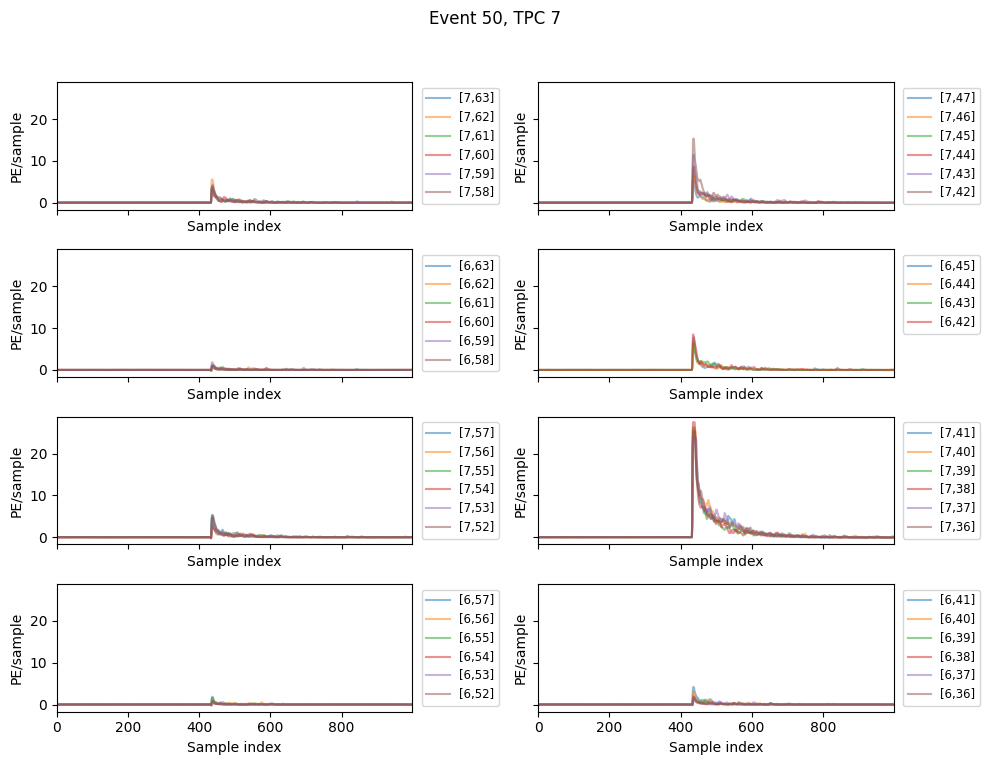

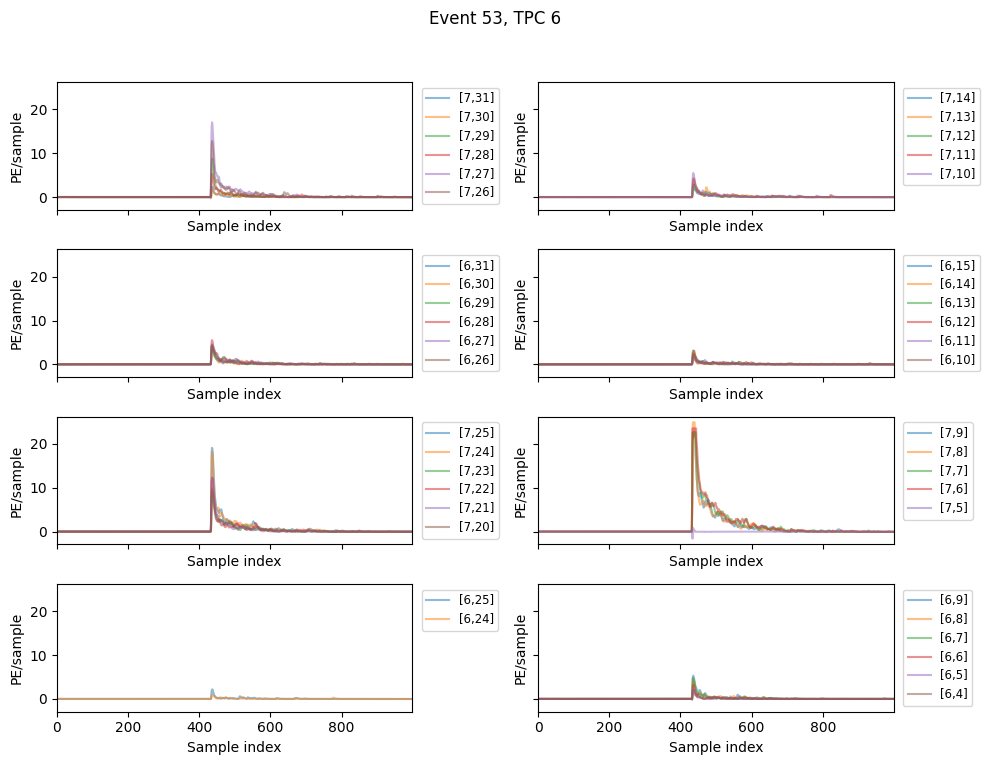

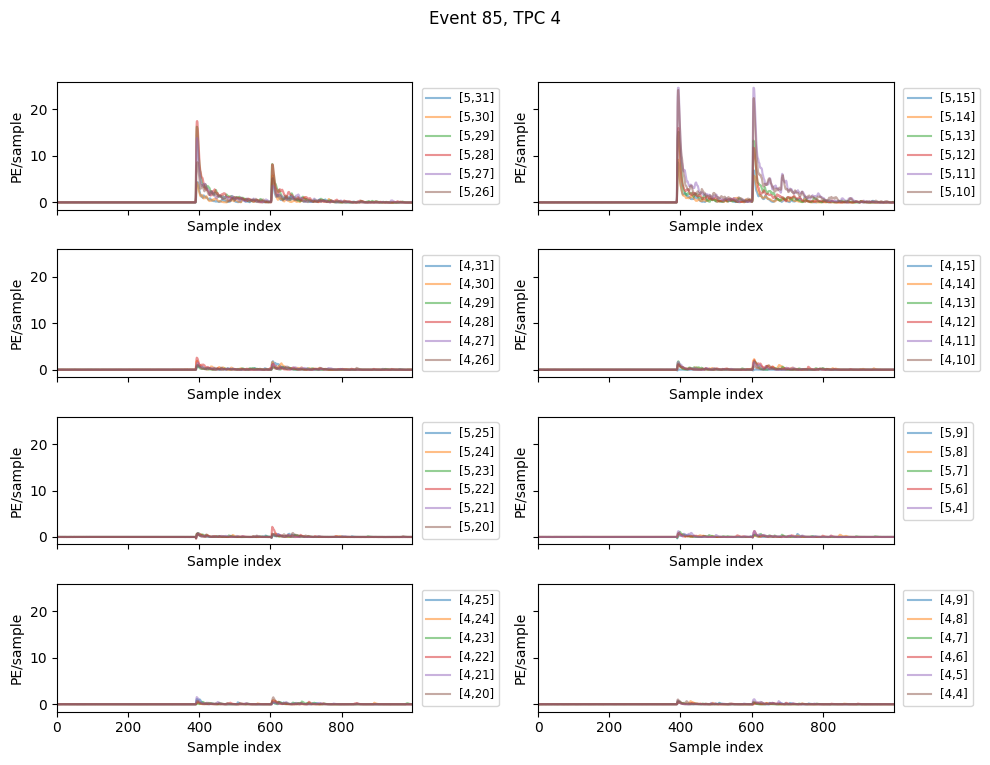

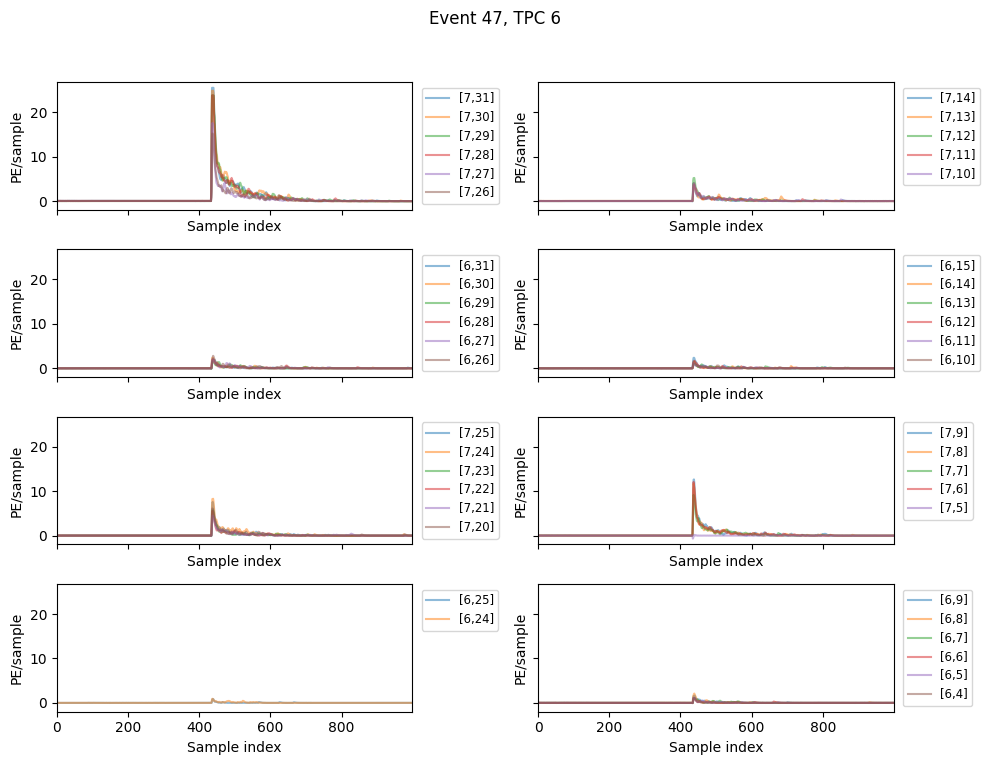

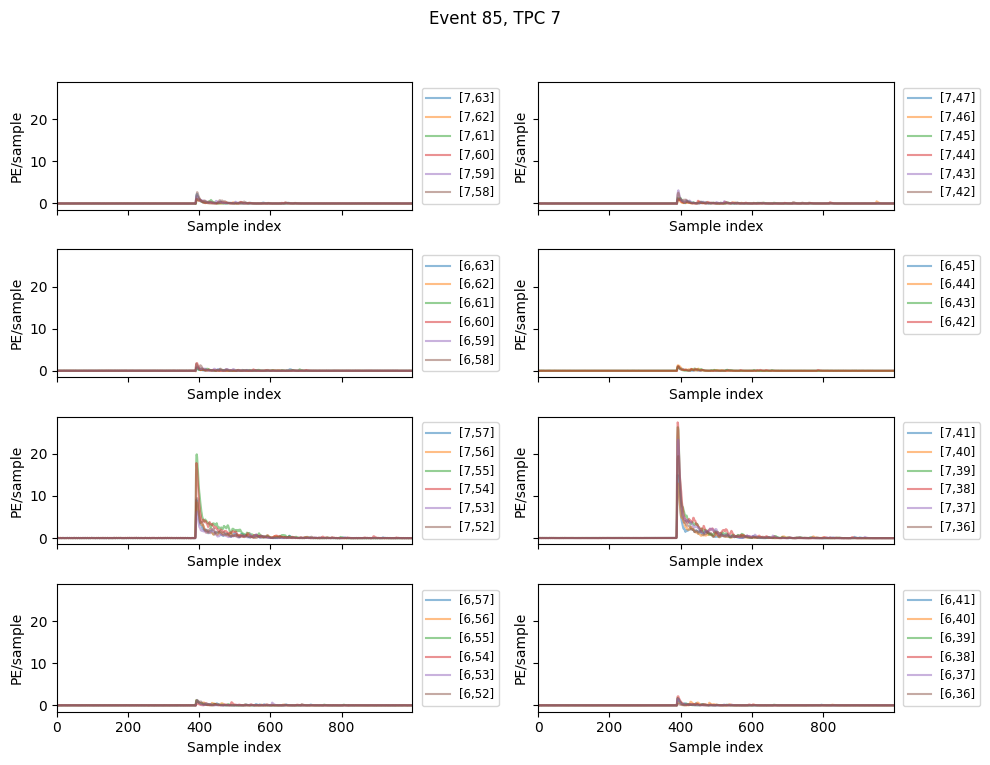

In [ ]:
# Plot waveforms for the top 5 ranking event and TPC
for idx in top_indices:
    tpc_idx, event_idx = np.unravel_index(idx, tpc_integrals_arr.shape)
    plot_tpc_waveforms(cwvfms, event_idx, tpc_idx, channel_status=channel_status)

You might notice in the 2nd example here that some of the waveforms are clipped (reaching the 14bit ADC maximum shown in tutorial 1)

Our next step will be to demonstrate how we go from these processed waveforms to hit level information.

# Here's a challenge!
## Can you run this on 2x2 MC?
## Can you generalise this to FSD?